In [60]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

In [61]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    distance=[]
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance.append(r)
    return(x,y,distance,theta)  
    
n=10000 #int(input("how many steps?"))
alpha=2 #int(input("what's the scale?"))
beta=5 #int(input("what's the shape?"))
c=0.9# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
r_original=data[2]# this is a vector of step-lengths
theta_original=data[3]# this is a vector of headings
t=range(0,n)

In [62]:
# my code pretty much starts here
time_step=2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [63]:
x_new=f(t_new)
y_new=g(t_new)

In [64]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))

4999
4999
4999
4998
4998


In [65]:
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter#MCMC sampler for the heading

In [66]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.02 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))



Acceptance rate = 0.4111


0.815727585991
0.815676245131
19001


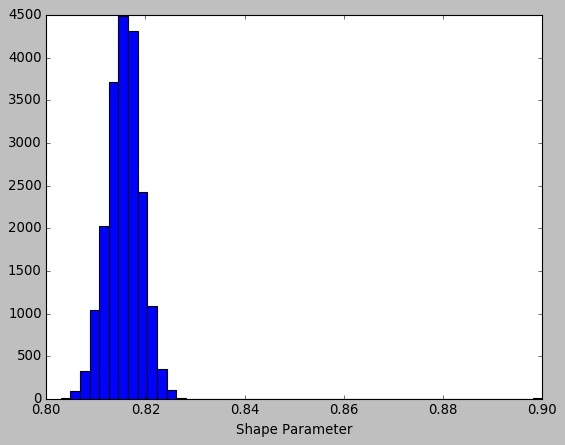

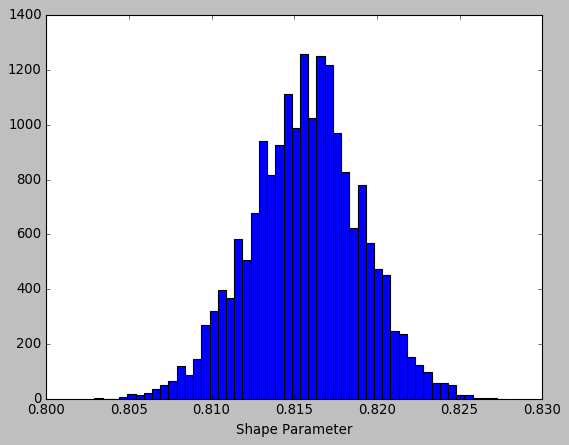

In [67]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [68]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.06,0.06] # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3806


25001
5.97644252986
3.81975410553


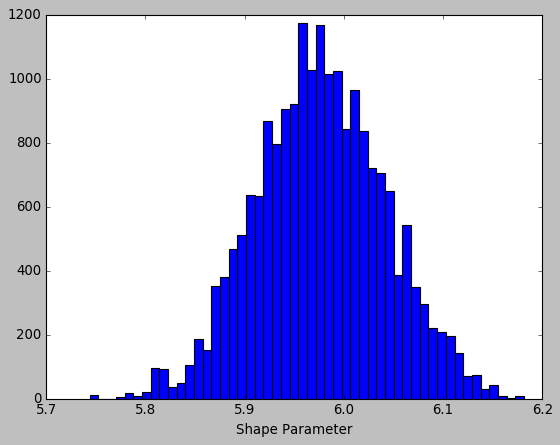

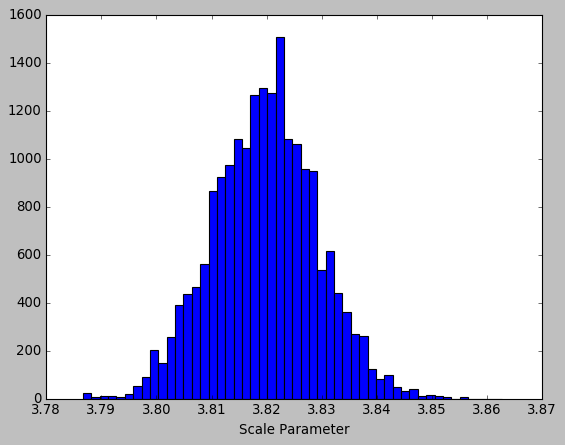

In [69]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)# now changing the parameters and n with the ones that I got
plt.xlabel("Scale Parameter")
plt.show()# now changing the parameters and n with the ones that I got



In [70]:
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[]
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance.append(r)# save the distances r for the mcmc sampler
    return [x_change,y_change,distance,theta]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
x_change = np.array(rw2_change(n_change)[0])
y_change=np.array(rw2_change(n_change)[1])
data_change=np.array(rw2_change(n_change)[2])
theta_change=np.array(rw2_change(n_change)[3])


In [71]:
T_y_weibull=log_likelihood(r_original,5,2)
T_y_wc=log_wclikelihood(theta_original,c,0)
# T_y in total
T_y=T_y_weibull+T_y_wc
T_y

array([-46309.7513])

In [72]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-100]# same length now
scale_parameters_need=scale_parameters[::10][:-100]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))

1901
1901
1901


In [73]:
#data_change-step-lengths after the change of the parameters after inference
#theta_change-headings after the change of the parameters after inference

In [74]:
T_y_rep_weibull=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)-1):
    T_y_rep_weibull[i]=log_likelihood(data_change,shape_parameters_need[i],scale_parameters_need[i])

In [75]:
print(len(T_y_rep_weibull))
T_y_rep_weibull

1901


array([-8622.4492, -8623.3542, -8626.7003, ..., -8622.9881, -8621.9461,
           0.    ])

In [76]:
count_zeros=0
for i in range(len(shape_parameters_need)-1):
    if T_y_rep_weibull[i]==0:
        count_zeros+=1
count_zeros

0

In [77]:
T_y_rep_wc=np.zeros(len(shapewc_parameters_need))
for i in range(len(shapewc_parameters_need)-1):
    T_y_rep_wc[i]=log_wclikelihood(theta_change,shapewc_parameters_need[i],0)


In [78]:
count_zeros=0
for i in range(len(shapewc_parameters_need)-1):
    if T_y_rep_wc[i]==0:
        count_zeros+=1
count_zeros

0

In [79]:
print(len(T_y_rep_wc))
T_y_rep_wc

1901


array([-14416.5831, -14339.2571, -14417.2786, ..., -14299.0065,
       -14299.0065,      0.    ])

In [80]:
T_y_rep=T_y_rep_weibull+T_y_rep_wc   
T_y_rep

array([-23039.0323, -22962.6114, -23043.9789, ..., -22921.9947,
       -22920.9526,      0.    ])

In [81]:
count=0
for i in range(len(shape_parameters_need)-1):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters)
print(ppp_value)


1900
1901
0.09499525023748813


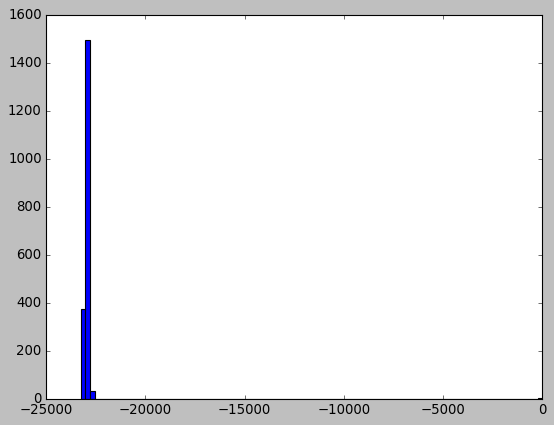

In [82]:
plt.hist(T_y_rep,bins=100)
plt.show()